In [1]:
import numpy
from matplotlib import pyplot
import sys
sys.path.append('../src/')
import densities, conditionals
import pykalman

# Kalman filter

Here we use the Gaussian Toolbox to implement a Kalman filter which has the form

$$
z_{t} = A z_{t-1} + b + \zeta_t \\
x_{t} = C z_t + d + \xi_t,
$$

where $x_t$ are our observations and $z_t$ latent (unobserved) variables. Furthermore, the noise variables are

$$
\zeta_t \sim N(0,Q_z)\\
\xi_t \sim N(0,Q_x).
$$

In [158]:
class KalmanFilter:
    
    def __init__(self, X: numpy.ndarray, A: numpy.ndarray, b: numpy.ndarray, Qz: numpy.ndarray, 
                 C: numpy.ndarray, d: numpy.ndarray, Qx: numpy.ndarray):
        """ This is a linear Kalman filter.
        """
        self.Dz, self.Dx = Qz.shape[0], Qx.shape[0]
        self.T = X.shape[0]
        self.X = X
        self.state_density = conditionals.ConditionalGaussianDensity(numpy.array([A]), numpy.array([b]), numpy.array([Qz]))
        self.emission_density = conditionals.ConditionalGaussianDensity(numpy.array([C]), numpy.array([d]), numpy.array([Qx]))
        self.prediction_density = self._setup_density()
        self.filter_density = self._setup_density()
        
    def _setup_density(self):
        Sigma = numpy.tile(numpy.eye(self.Dz)[None], (self.T+1,1,1))
        Lambda = numpy.tile(numpy.eye(self.Dz)[None], (self.T+1,1,1))
        mu = numpy.zeros((self.T + 1, self.Dz))
        ln_det_Sigma = self.Dz * numpy.log(numpy.ones(self.T+1))
        return densities.GaussianDensity(Sigma, mu, Lambda, ln_det_Sigma)
        
        
    def forward_path(self):
        """ Forward iteration.
        """
        for t in range(1, self.T+1):
            self.prediction(t)
            self.filtering(t)
        
        
    def prediction(self, t: int):
        """ Here the prediction density is calculated.
        
        p(z_t|x_1:t-1) = int p(z_t|z_t-1)p(z_t-1|x_1:t-1) dz_t-1
        """
        # p(z_t-1|x_{1:t-1})
        pre_filter_density = self.filter_density.slice([t-1])
        # p(z_t|x_{1:t-1})
        cur_prediction_density = pre_filter_density.affine_marginal_transformation(self.state_density)
        # Write result into prediction density collection
        self.prediction_density.update([t], cur_prediction_density)
        
        
    def filtering(self, t: int):
        """ Here the filtering density is calculated.
        
        p(z_t|x_{1:t}) = p(x_t|z_t)p(z_t|x_{1:t-1}) / p(x_t)
        """
        # p(z_t|x_{1:t-1})
        cur_prediction_density = self.prediction_density.slice([t])
        # p(z_t| x_t, x_{1:t-1})
        p_z_given_x = cur_prediction_density.affine_conditional_transformation(self.emission_density)
        # Condition on x_t
        cur_filter_density = p_z_given_x.condition_on_x(self.X[t-1:t])
        # Write result into filter density collection
        self.filter_density.update([t], cur_filter_density)
        
    def compute_log_likelihood(self):
        llk = 0
        px = self.prediction_density.affine_marginal_transformation(self.emission_density)
        for t in range(1,self.T+1):
            cur_px = px.slice([t])
            llk += cur_px.evaluate_ln(self.X[t-1:t])[0,0]
        return llk
            
        
class KalmanSmoother(KalmanFilter):
    
    def __init__(self, X: numpy.ndarray, A: numpy.ndarray, b: numpy.ndarray, Qz: numpy.ndarray, 
                 C: numpy.ndarray, d: numpy.ndarray, Qx: numpy.ndarray):
        super().__init__(X, A, b, Qz, C, d, Qx)
        self.smoothing_density = self._setup_density()
        
    def backward_path(self):
        """ Backward iteration.
        """
        last_filter_density = self.filter_density.slice([self.T])
        self.smoothing_density.update([self.T], last_filter_density)
        
        for t in numpy.arange(self.T-1,-1,-1):
            self.smoothing(t)
                    
    def smoothing(self, t: int):
        """ Here we do the smoothing step.
        
        First we calculate the backward density
        
        p(z_{t} | z_{t+1}, x_{1:t}) = p(z_{t+1}|z_t)p(z_t | x_{1:t}) / p(z_{t+1}| x_{1:t}) 
        
        and finally we get the smoothing density
        
        p(z_{t} | x_{1:T}) = int p(z_{t} | z_{t+1}, x_{1:t}) p(z_{t+1}|x_{1:T}) dz_{t+1}
        """
        # p(z_{t} | x_{1:t}) 
        cur_filter_density = self.filter_density.slice([t])
        # p(z_{t} | z_{t+1}, x_{1:t}) 
        backward_density = cur_filter_density.affine_conditional_transformation(self.state_density)
        # p(z_{t+1} | x_{1:T})
        post_smoothing_density = self.smoothing_density.slice([t+1])
        # p(z_{t} | x_{1:T})
        cur_smoothing_density = post_smoothing_density.affine_marginal_transformation(backward_density)
        # Write result into smoothing density collection
        self.smoothing_density.update([t], cur_smoothing_density)
        

In [159]:
T = 1000
trange = numpy.arange(T)
Dx = 2
Dz = 2
X = numpy.empty((T,Dx))
X[:,0] = numpy.sin(trange / 20)
X[:,1] = numpy.cos(trange / 10)
noise_x = .1
noise_z = .1
X += noise_x * numpy.random.randn(*X.shape)
Qx = noise_x ** 2 * numpy.eye(Dx)
Qz = noise_z ** 2 * numpy.eye(Dz)
A, b = numpy.eye(Dz), numpy.zeros((Dz,))
#A[0,1] = 1
C, d = numpy.eye(Dx), numpy.zeros((Dx,))

ks = KalmanSmoother(X, A, b, Qz, C, d, Qx)

In [160]:
ks.forward_path()
ks.backward_path()

In [161]:
pykf = pykalman.KalmanFilter(n_dim_obs=2, n_dim_state=2, 
                             transition_matrices=A, transition_offsets=b, transition_covariance=Qz,
                             observation_matrices=C, observation_offsets=d, observation_covariance=Qx,
                             initial_state_mean=numpy.zeros(Dz), initial_state_covariance=numpy.eye(Dz))
py_smoother_mu, py_smoother_Sigma = pykf.smooth(X)

In [162]:
py_smoother_mu[-2], ks.smoothing_density.mu[-2]

(array([-0.29065346,  0.710537  ]), array([-0.29065346,  0.710537  ]))

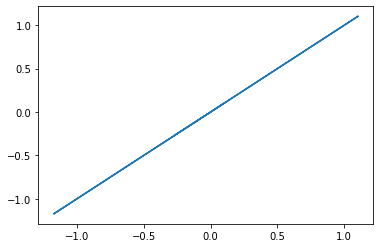

In [163]:
pyplot.plot(py_smoother_mu[:,0],ks.smoothing_density.mu[1:,0])

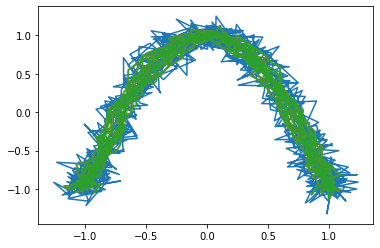

In [164]:
pyplot.plot(X[:,0], X[:,1])
#pyplot.plot(ks.filter_density.mu[:,0], ks.filter_density.mu[:,1])
pyplot.plot(py_smoother_mu[:,0], py_smoother_mu[:,1])
pyplot.plot(ks.smoothing_density.mu[:,0], ks.smoothing_density.mu[:,1])

In [165]:
em_result = pykf.em(X, n_iter=10, em_vars=['transition_convariance'])

In [166]:
em_result.observation_covariance

array([[0.01, 0.  ],
       [0.  , 0.01]])

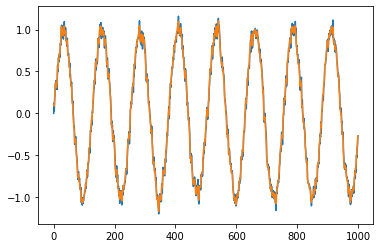

In [167]:
pyplot.plot(ks.filter_density.mu[:,0])
pyplot.plot(ks.smoothing_density.mu[:,0])

In [168]:
class StateSpace_EM:
    
    def __init__(self, X: numpy.ndarray, Dz: int, noise_x: float=.1, noise_z: float=.1):
        self.T, self.Dx = X.shape
        self.Dz = Dz
        self.Qx = noise_x ** 2 * numpy.eye(self.Dx)
        self.Qz = noise_z ** 2 * numpy.eye(self.Dz)
        self.Qz_inv = numpy.linalg.inv(self.Qz)
        self.A, self.b = numpy.eye(self.Dz), numpy.zeros((self.Dz,))
        self.C, self.d = numpy.random.randn(self.Dx, self.Dz), numpy.zeros((self.Dx,))
        if self.Dx == self.Dz:
            self.C = numpy.eye(self.Dz)
        self.ks = KalmanSmoother(X, self.A, self.b, self.Qz, self.C, self.d, self.Qx)
        self.Qz_inv, self.ln_det_Qz = self.ks.state_density.Lambda[0], self.ks.state_density.ln_det_Sigma[0]
        self.Qx_inv, self.ln_det_Qx = self.ks.emission_density.Lambda[0], self.ks.emission_density.ln_det_Sigma[0]
        
    def run_em(self, n_iter=100):
        #Q_list = []
        llk_list = []
        for i in range(n_iter):
            self.estep()
            #Q_list.append(self.compute_Q())
            llk_list.append(self.compute_log_likelihood())
            print(i, llk_list[-1])
            self.mstep()
            #Q_list.append(self.compute_Q())
        return llk_list
    
    def estep(self):
        self.ks.forward_path()
        self.ks.backward_path()
        
    def mstep(self):
        #self.update_A()
        #self.update_b()
        #self.update_Qz()
        #self.update_state_density()
        self.update_C()
        self.update_d()
        self.update_Qx()
        self.update_emission_density()
        self.update_init_density() # Checked
        
    def get_marginal_likelihood(self):
        return numpy.sum(self.ks.filter_density.lnZ)
        
    def compute_Q(self):
        """ Calculates the Qfunction. (TODO: Still a small bug here, somewhere!)
        """
        # E[(z_t - Az_{t-1} - b)'Qz^{1}(z_{t} - Az_{t-1} - b)]
        joint_density = ssm.ks.smoothing_density.affine_joint_transformation(ssm.ks.state_density)
        A = numpy.hstack([-self.A, numpy.eye(self.Dz)])
        a = -self.b
        B = numpy.dot(self.Qz_inv, A)
        b = -numpy.dot(self.Qz_inv, ssm.b)
        Ezz = numpy.sum(joint_density.integrate('Ax_aBx_b_inner', A_mat=A, a_vec=a, B_mat=B, b_vec=b)[:-1])
        Ezz += self.T * (self.ln_det_Qz + self.Dz * numpy.log(2 * numpy.pi))
        # E[(x_t - Cz_{t} - d)'Qx^{-1}(x_{t} - Cz_{t} - d)]
        A = -self.C
        a_t = self.ks.X - self.d[None]
        B = numpy.dot(self.Qx_inv, A)
        b_t = numpy.dot(self.Qx_inv, a_t.T).T
        Exx = 0
        for t in range(1,self.T+1):
            cur_smooth_density = self.ks.smoothing_density.slice([t])
            Exx += cur_smooth_density.integrate('Ax_aBx_b_inner', A_mat=A, a_vec=a_t[t-1], B_mat=B, b_vec=b_t[t-1])[0]
        Exx += self.T * (self.ln_det_Qx + self.Dx * numpy.log(2 * numpy.pi))
        # E[(z_0 - mu0)'Sigma0^{-1}(z_0 - mu0)]
        init_smooth_density = self.ks.smoothing_density.slice([0])
        A = numpy.eye(self.Dz)
        a = -self.ks.filter_density.mu[0]
        B = self.ks.filter_density.Lambda[0]
        b = numpy.dot(self.ks.filter_density.Lambda[0], a)
        Ez0 = init_smooth_density.integrate('Ax_aBx_b_inner', A_mat=A, a_vec=a, B_mat=B, b_vec=b)[0]
        Ez0 += self.ks.filter_density.ln_det_Sigma[0] + self.Dz * numpy.log(2 * numpy.pi)
        return - .5 * (Exx + Ezz + Ez0)
    
    def update_A(self):
        joint_density = ssm.ks.smoothing_density.affine_joint_transformation(ssm.ks.state_density)
        Ezz = joint_density.integrate('xx')[:-1]
        Ezz_past = numpy.sum(Ezz[:,:self.Dz, :self.Dz], axis=0)
        mu_b = self.ks.smoothing_density.mu[:-1,None] * self.b[None,:,None]
        Ezz_cross = numpy.sum(Ezz[:, self.Dz:, :self.Dz] - mu_b, axis=0)
        self.A = numpy.linalg.solve(Ezz_past, Ezz_cross).T
        
    def update_b(self):
        self.b = numpy.mean(self.ks.smoothing_density.mu[1:] - numpy.dot(self.A, self.ks.smoothing_density.mu[:-1].T).T, axis=0)
    
    def update_Qz(self):
        joint_density = ssm.ks.smoothing_density.affine_joint_transformation(ssm.ks.state_density)
        A = numpy.hstack([-self.A, numpy.eye(self.Dz)])
        a = -self.b
        self.Qz =  numpy.mean(joint_density.integrate('Ax_aBx_b_outer', A_mat=A, a_vec=a, B_mat=A, b_vec=a)[:-1], axis=0)
        
    def update_state_density(self):
        self.ks.state_density = conditionals.ConditionalGaussianDensity(numpy.array([self.A]), 
                                                                        numpy.array([self.b]), 
                                                                        numpy.array([self.Qz]))
        self.Qz_inv, self.ln_det_Qz = self.ks.state_density.Lambda[0], self.ks.state_density.ln_det_Sigma[0]
        
    def update_Qx(self):
        A = -self.C
        a_t = self.ks.X - self.d[None]
        Exx = numpy.zeros((self.Dx, self.Dx))
        for t in range(1,self.T+1):
            cur_smooth_density = self.ks.smoothing_density.slice([t])
            Exx += cur_smooth_density.integrate('Ax_aBx_b_outer', A_mat=A, a_vec=a_t[t-1], B_mat=A, b_vec=a_t[t-1])[0]
        self.Qx = Exx / self.T
        
    def update_C(self):
        Ezz = numpy.sum(self.ks.smoothing_density.integrate('xx')[1:], axis=0)
        Ez = self.ks.smoothing_density.integrate('x')[1:]
        zx = numpy.sum(Ez[:,:,None] * (self.ks.X[:,None] - self.d[None,None]), axis=0)
        self.C = numpy.linalg.solve(Ezz, zx).T
        
    def update_d(self):
        Ez = self.ks.smoothing_density.integrate('x')[1:]
        self.d = numpy.mean(self.ks.X - numpy.dot(self.C, Ez.T).T, axis=0)
        
    def update_emission_density(self):
        self.ks.emission_density = conditionals.ConditionalGaussianDensity(numpy.array([self.C]),
                                                                           numpy.array([self.d]), 
                                                                           numpy.array([self.Qx]))
        self.Qx_inv, self.ln_det_Qx = self.ks.emission_density.Lambda[0], self.ks.emission_density.ln_det_Sigma[0]
        
    def update_init_density(self):
        init_smooth_density = self.ks.smoothing_density.slice([0])
        mu0 = init_smooth_density.integrate('x')
        Sigma0 = init_smooth_density.integrate('Ax_aBx_b_outer', A_mat=None, a_vec=-mu0[0], B_mat=None, b_vec=-mu0[0])
        opt_init_density = densities.GaussianDensity(Sigma0, mu0)
        self.ks.filter_density.update([0], opt_init_density)
        
    def compute_log_likelihood(self):
        return self.ks.compute_log_likelihood()

In [172]:
ssm = StateSpace_EM(X, Dz=2,)
Qlist = ssm.run_em(n_iter=100)

0 945.4746404498318
1 979.8161107182932
2 992.7290554548874
3 998.801851205399
4 1002.0594723405158
5 1004.0599217679924
6 1005.4622490716474
7 1006.5629462547093
8 1007.5017905280099
9 1008.3472777558334
10 1009.1341800988611
11 1009.8807928783762
12 1010.5971306078478
13 1011.288933377019
14 1011.9596741425227
15 1012.6115878278665
16 1013.2462110986145
17 1013.8646722815758
18 1014.4678510961129
19 1015.0564691204602
20 1015.631142580753
21 1016.1924141510277
22 1016.7407727577934
23 1017.2766663404433
24 1017.800510356765
25 1018.3126936435384
26 1018.8135825856855
27 1019.3035241736627
28 1019.7828483106737
29 1020.2518696012003
30 1020.7108887725784
31 1021.1601938313842
32 1021.6000610242717
33 1022.0307556517631
34 1022.4525327695002
35 1022.8656378018095
36 1023.2703070855764
37 1023.6667683581203
38 1024.0552411989893
39 1024.4359374334272
40 1024.8090615035105
41 1025.174810811443
42 1025.5333760388328
43 1025.884941444751
44 1026.2296851450178
45 1026.5677793747157
46 1026.

In [170]:
pykf = pykalman.KalmanFilter(n_dim_obs=2, n_dim_state=2, 
                             transition_matrices=A, transition_offsets=b, transition_covariance=Qz,
                             observation_matrices=C, observation_offsets=d, observation_covariance=Qx,
                             initial_state_mean=numpy.zeros(Dz), initial_state_covariance=numpy.eye(Dz))
em_result = pykf.em(X, n_iter=20, em_vars=['observation_matrices', 'observation_offsets', 'observation_covariance', 
                                           'initial_state_mean', 'initial_state_covariance'])

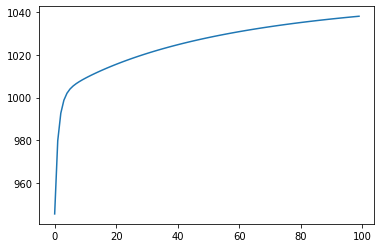

In [173]:
pyplot.plot(Qlist)

In [146]:
ssm.C, em_result.observation_matrices

(array([[9.72981134e-01, 1.61803510e-06],
        [6.90278872e-05, 9.74990910e-01]]),
 array([[ 9.73134116e-01, -4.97278899e-05],
        [ 8.03295505e-05,  9.75300472e-01]]))

In [147]:
ssm.Qx, em_result.observation_covariance

(array([[ 6.35965873e-03, -7.83605015e-05],
        [-7.83605015e-05,  6.52343374e-03]]),
 array([[ 6.34958876e-03, -7.87764699e-05],
        [-7.87764699e-05,  6.51153924e-03]]))

In [151]:
ssm.ks.filter_density.Sigma[0], em_result.initial_state_covariance

(array([[ 7.35104542e-04, -1.75244649e-06],
        [-1.75244649e-06,  7.38770881e-04]]),
 array([[ 2.34462419e-04, -1.80114899e-06],
        [-1.80114899e-06,  2.38180554e-04]]))

In [152]:
ssm.ks.filter_density.mu[0], em_result.initial_state_mean

(array([0.03739009, 0.99231526]), array([0.03733501, 0.99277656]))

In [118]:
em_result.loglikelihood(X)

ValueError: masked arrays are not supported

In [150]:
ssm.C, em_result.observation_matrices

(array([[9.72981134e-01, 1.61803510e-06],
        [6.90278872e-05, 9.74990910e-01]]),
 array([[ 9.73134116e-01, -4.97278899e-05],
        [ 8.03295505e-05,  9.75300472e-01]]))

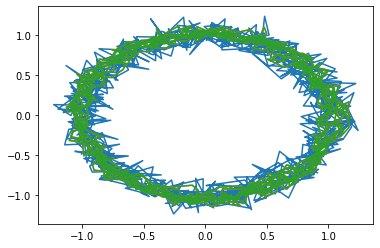

In [149]:
py_smoother_mu, py_smoother_Sigma = em_result.smooth(X)
pyplot.plot(X[:,0], X[:,1])
#pyplot.plot(ks.filter_density.mu[:,0], ks.filter_density.mu[:,1])
pyplot.plot(py_smoother_mu[:,0], py_smoother_mu[:,1])
pyplot.plot(ssm.ks.smoothing_density.mu[:,0], ssm.ks.smoothing_density.mu[:,1])

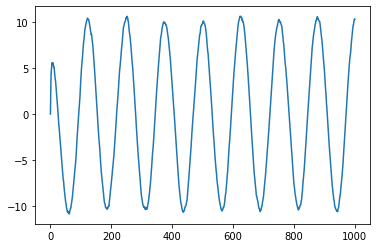

In [37]:
pyplot.plot(ssm.ks.filter_density.mu[:,0])

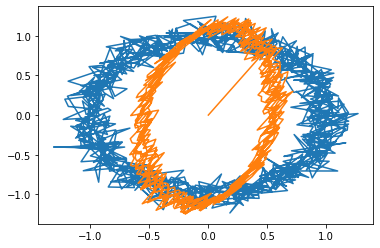

In [38]:
X_pred = numpy.dot(ssm.C, ssm.ks.filter_density.mu.T).T
pyplot.plot(X[:,0], X[:,1])
pyplot.plot(X_pred[:,0], X_pred[:,1])

IndexError: index 1 is out of bounds for axis 1 with size 1

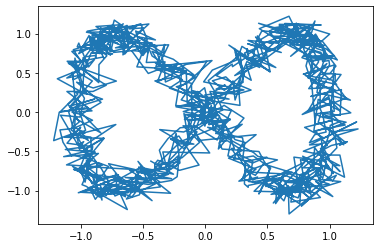

In [166]:
pyplot.plot(X[:,0], X[:,1])
pyplot.plot(ssm.ks.filter_density.mu[:,0], ssm.ks.filter_density.mu[:,1])
pyplot.plot(ssm.ks.smoothing_density.mu[:,0], ssm.ks.smoothing_density.mu[:,1])

In [151]:
ssm.calculate_Q()

-25381.384176530253

In [152]:
ssm.update_state_covariance()

In [153]:
ssm.Qz

array([[0.01]])

In [154]:
ssm.update_emission_covariance()

In [155]:
ssm.Qx

array([[0.26128986, 0.21600792],
       [0.21600792, 0.31933797]])

In [156]:
ssm.update_A()
ssm.update_b()

In [157]:
ssm.update_C()
ssm.update_d()

(2, 1) (1000, 1)


In [ ]:
joint_density = ssm.ks.smoothing_density.affine_joint_transformation(ssm.ks.state_density)
ssm.Qz_inv.shape 

In [226]:
A = numpy.hstack([-ssm.A, numpy.eye(ssm.Dz)])
a = -ssm.b
B = numpy.dot(ssm.Qz_inv, A)
b = -numpy.dot(ssm.Qz_inv, ssm.b)
- .5 * numpy.sum(joint_density.integrate('Ax_aBx_b_inner', A_mat=A, a_vec=a, B_mat=B, b_vec=b))

-1001.0000000000002

In [211]:
B.shape

(2, 4)